# Image Classification with CNN
Training a convolutional neural network for product category classification

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import json

## Configuration

In [37]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 10

# Paths
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/validation'
TEST_DIR = 'data/test'
MODEL_PATH = 'models/product_classifier.keras'
HISTORY_PATH = 'output/training_history.json'

print(f"Using TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

Using TensorFlow version: 2.20.0-dev0+selfbuilt
GPU Available: []


## Data Loading and Augmentation

In [38]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class labels: {train_generator.class_indices}")

Found 800 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


Training samples: 800
Validation samples: 150
Test samples: 150
Class labels: {'automotive': 0, 'beauty': 1, 'books': 2, 'clothing': 3, 'electronics': 4, 'food': 5, 'furniture': 6, 'home_garden': 7, 'sports': 8, 'toys': 9}


## Model Architecture

In [39]:
def build_cnn_model(input_shape, num_classes):
    """
    Build a CNN model for image classification
    """
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
model = build_cnn_model(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=NUM_CLASSES
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,401,162 (74.01 MB)

 Trainable params: 19,399,178 (74.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Compile Model

In [40]:
# Compile model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3)]
)

print("Model compiled successfully!")

Model compiled successfully!


## Callbacks

In [41]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Model checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

callbacks = [early_stopping, reduce_lr, checkpoint]

## Train Model

In [42]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 744ms/step - accuracy: 0.7887 - loss: 0.6514 - top_k_categorical_accuracy: 0.9375 - val_accuracy: 0.1000 - val_loss: 8.4453 - val_top_k_categorical_accuracy: 0.3000 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 725ms/step - accuracy: 0.9013 - loss: 0.2765 - top_k_categorical_accuracy: 0.9975 - val_accuracy: 0.1000 - val_loss: 8.6513 - val_top_k_categorical_accuracy: 0.3067 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 728ms/step - accuracy: 0.9525 - loss: 0.1499 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.1000 - val_loss: 13.6695 - val_top_k_categorical_accuracy: 0.3000 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 743ms/step - accuracy: 0.9613 - loss: 0.1180 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.1000 - val_loss: 12.5706 - val_top_k_categorical_accuracy: 0.3000 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 733ms/step - accuracy: 0.9787 - 

## Plot Training History

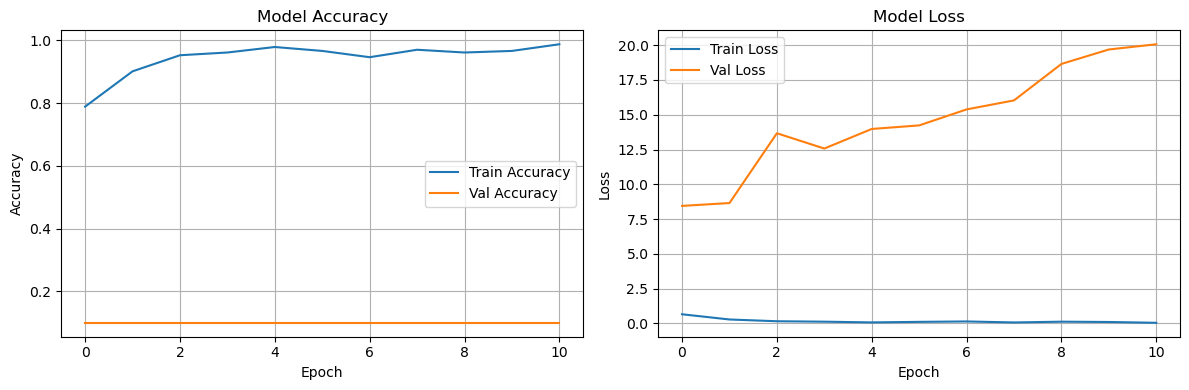

In [43]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('output/training_history.png')
plt.show()

## Evaluate on Test Set

In [44]:
# Evaluate on test set
test_loss, test_acc, test_top3_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Top-3 Accuracy: {test_top3_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.1000 - loss: 8.4792 - top_k_categorical_accuracy: 0.3000

Test Accuracy: 0.1000
Test Top-3 Accuracy: 0.3000
Test Loss: 8.4792
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step

Classification Report:
              precision    recall  f1-score   support

  automotive       0.00      0.00      0.00        15
      beauty       0.00      0.00      0.00        15
       books       0.00      0.00      0.00        15
    clothing       0.10      1.00      0.18        15
 electronics       0.00      0.00      0.00        15
        food       0.00      0.00      0.00        15
   furniture       0.00      0.00      0.00        15
 home_garden       0.00      0.00      0.00        15
      sports       0.00      0.00      0.00        15
        toys       0.00      0.00      0.00        15

    accuracy                           0.10       150
   macro avg       0.01      0.10      0.02       150
weighted avg       0.01      0.10      0.02       150


/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Confusion Matrix

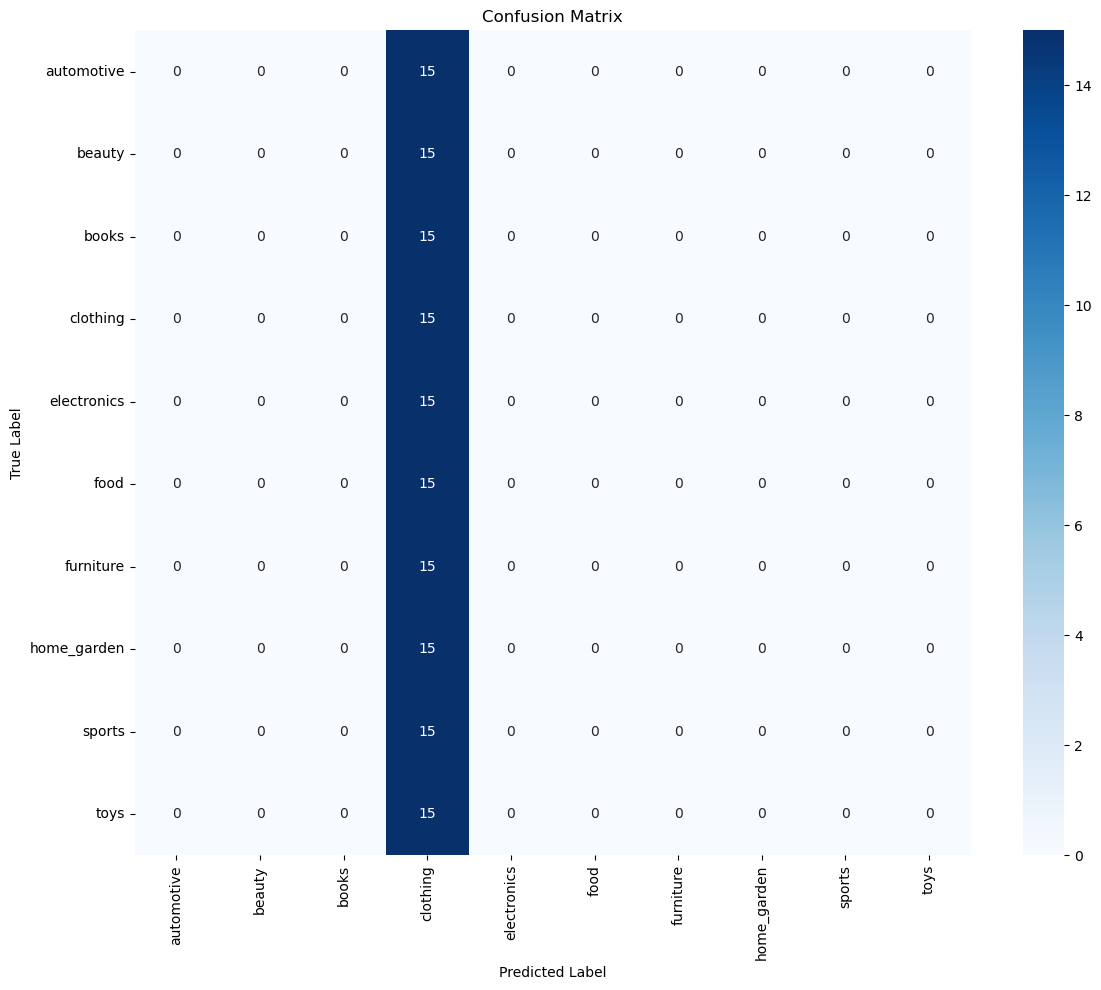

In [45]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('output/confusion_matrix.png')
plt.show()

## Save Model and Metadata

In [46]:
# Save final model
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Save training history
with open(HISTORY_PATH, 'w') as f:
    json.dump(history.history, f)

# Save class indices
with open('models/class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

# Save model metadata
metadata = {
    'img_size': IMG_SIZE,
    'num_classes': NUM_CLASSES,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'class_names': class_names
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved!")

Model saved to models/product_classifier.keras
Metadata saved!


## Inference Function

In [50]:
def predict_image(image_path, model_path='models/product_classifier.keras'):
    """
    Predict class for a single image
    """
    # Load model
    model = keras.models.load_model(model_path)

    # Load and preprocess image
    img = keras.preprocessing.image.load_img(
        image_path,
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    # Load class names
    with open('models/class_indices.json', 'r') as f:
        class_indices = json.load(f)

    # Reverse mapping
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_label = idx_to_class[predicted_class]

    return predicted_label, confidence, predictions[0]

# Test the function
test_image = 'data/test/sample_product.jpg'
label, conf, probs = predict_image(test_image)
print(f"\nPredicted class: {label}")
print(f"Confidence: {conf:.4f}")
# print(f"Probs: {probs}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Predicted class: clothing
Confidence: 0.9958
